# Reinforcement Learning

# 5. Gradient Methods

This notebook presents gradient methods, useful for learning in some environment with a large state space.

We use a neural network with a single hidden layer.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from utils.agent import Agent, OnlineEvaluation
from utils.dynamic import ValueIteration
from utils.model import TicTacToe, Nim, ConnectFour

%matplotlib inline

In [2]:
from IPython.core.display import display, HTML

def display_answer(title, answer):
    if isinstance(answer, list):
        string_display = f"""<div class="alert alert-block alert-success"> <h1>{title}:</h1><ul>"""
        for a in answer:
            string_display += f"<li>{a}</li>"
        string_display += "</ul></div>"
    elif isinstance(answer, str):
        string_display = f"""<div class="alert alert-block alert-success"> <h1>{title}:</h1>{answer} </div>"""
    else:
        raise ValueError("Answer should be a string or a list of strings.")
    display(HTML(string_display))

## Value gradient

We start with value-based methods. The neural network is a regressor that approximates the value function. Note that the model is supposed to be known, so that we don't need the action-value function.

In [3]:
class Regressor(nn.Module):
    """Neural network for value function approximation. Return the value of each state."""
    def __init__(self, model, hidden_size):
        if not hasattr(model, 'one_hot_encode'):
            raise ValueError("The environment must have a one-hot encoding of states.")   
        super(Regressor, self).__init__()
        self.model = model
        state = model.init_state()
        code = model.one_hot_encode(state)
        input_size = len(code)
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size), 
            nn.GELU(), 
            nn.Linear(hidden_size, 1))

    def forward(self, code):
        """Forward pass."""
        return self.nn(code)

In [4]:
game = TicTacToe()
regressor = Regressor(model=game, hidden_size=100)

state = game.state
# one-hot encoding
code = game.one_hot_encode(state)
# tensor
code = torch.tensor(code).float()

value = regressor.forward(code).detach()
# value of the state
print(value)

tensor([0.0747])


## To do

* Complete the method get_best_actions of the class ValueGradient. 
* Test the agent on TicTacToe, against (1) a random adversary and (2) a perfect adversary.
* Test the agent on ConnectFour, against (1) a random adversary and (2) an adversary with the one-step policy.
* Compare your results to another learning strategy (e.g., Monte-Carlo learning) and interpret the results.

In [21]:
class ValueGradient(OnlineEvaluation):
    """Agent learning by value gradient. The model is supposed to be known.
    
    Parameters
    ----------
    model : object of class Environment
        Model.
    player : int
        Player for games (1 or -1, default = default player of the game).
    gamma : float
        Discount rate (in [0, 1], default = 1).
    hidden_size : int
        Size of the hidden layer (default = 100).
    """
    def __init__(self, model, player=None, gamma=1, hidden_size=100):
        super(ValueGradient, self).__init__(model, player=player)  
        if not hasattr(model, "get_next_state"):
            raise ValueError("The model must be known, with a 'get_next_state' method.")
        self.nn = Regressor(model, hidden_size)
        self.gamma = gamma
        
    def get_best_actions(self, state):
        """Get the best actions in some state according to the value function.""" 
        actions = self.get_actions(state)
        if len(actions) > 1:
            # to be modified
            # if the state is terminal, take the actual value
            values = []
            for action in actions:
                next_state = self.model.get_next_state(state, action)
                if self.model.is_terminal(next_state):
                    values.append(self.model.get_reward(next_state))
                else:
                    code = self.model.one_hot_encode(next_state)
                    code = torch.tensor(code).float()
                    values.append(self.nn.forward(code).detach().item())
            
            if self.player == 1:
                best_value = max(values)
            else:
                best_value = min(values)
            actions = [action for action, value in zip(actions, values) if value==best_value]
        return actions        
    
    def update_policy(self):
        self.policy = self.get_policy()
    
    def get_samples(self, horizon, epsilon):
        """Get samples from one episode under the epsilon-greedy policy."""
        self.policy = self.randomize_policy(epsilon=epsilon)
        self.model.reset()
        state = self.model.state
        states = []
        rewards = []
        for t in range(horizon):
            action = self.get_action(state)
            reward, stop = self.model.step(action)
            states.append(state)
            rewards.append(reward)
            if stop:
                break
            state = self.model.state
        gains = []
        gain = 0
        for reward in reversed(rewards):
            gain = reward + self.gamma * gain
            gains.append(gain)
        return reversed(states), gains
        
    def train(self, horizon=100, n_episodes=1000, learning_rate=0.01, epsilon=0.1, desc=None):
        """Train the neural network with samples drawn from the epsilon-greedy policy."""
        optimizer = optim.Adam(self.nn.parameters(), lr=learning_rate)
        for t in tqdm(range(n_episodes), desc=desc):
            states, gains = self.get_samples(horizon, epsilon)
            codes = [self.model.one_hot_encode(state) for state in states]
            codes = np.array(codes)
            codes = torch.tensor(codes).float()
            values = self.nn.forward(codes)
            gains = torch.tensor(gains).float().reshape(-1, 1)
            mse = nn.MSELoss()
            loss = mse(values, gains)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [40]:
class MCLearning(OnlineEvaluation):
    """Online evaluation by Monte-Carlo."""

    def update_values(self, state=None, horizon=100):
        """Update the values from one episode."""
        stop, states, rewards = self.get_episode(state=state, horizon=horizon)
        # remove last state
        states.pop()
        gain = 0
        # backward update
        for state, reward in zip(reversed(states), reversed(rewards)):
            self.add_state(state)
            code = self.model.encode(state)
            self.count[code] += 1
            # to be modified
            # begin
            gain = reward + self.gamma * gain
            # end
            diff = gain - self.value[code]
            count = self.count[code]
            self.value[code] += diff / count


------------------------------------------------- Simulating TicTacToe -------------------------------------------------


Training TicTacToe with Value Gradient and random adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Training TicTacToe with MC learning and random adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Training TicTacToe with Value Gradient and perfect adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Training TicTacToe with MC learning and perfect adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

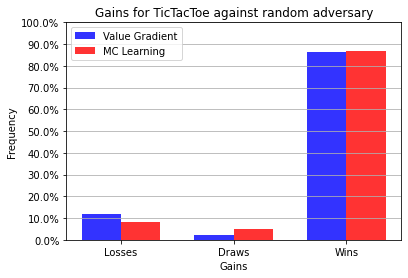

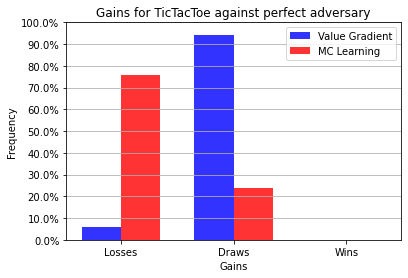

------------------------------------------------ Simulating ConnectFour ------------------------------------------------


Training ConnectFour with Value Gradient and random adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Training ConnectFour with MC learning and random adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Training ConnectFour with Value Gradient and one_step adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Training ConnectFour with MC learning and one_step adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

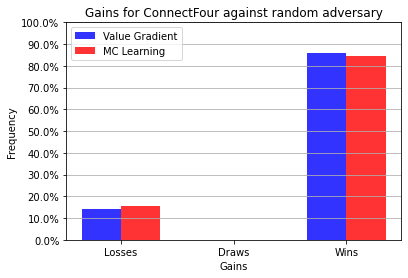

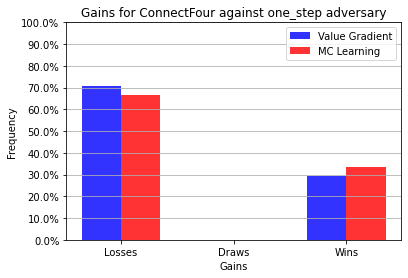

In [44]:
n_runs = 1000
n_episodes = 1000
issues = np.array([-1., 0., 1.])
gains = {}
adversary_policies = {'TicTacToe': ['random', 'perfect'], 'ConnectFour': ['random', 'one_step']}
for Game in [TicTacToe, ConnectFour]:
    print('-'*((120-13-len(Game.__name__))//2) + f' Simulating {Game.__name__} ' + '-'*((120-13-len(Game.__name__))//2))
    gains_game = {}

    for adversary_policy_name in adversary_policies[Game.__name__]:
        if adversary_policy_name == 'perfect':
            adversary_policy = ValueIteration(Game()).get_perfect_players()[1]
        else:
            adversary_policy = adversary_policy_name

        game = Game(adversary_policy=adversary_policy)

        # Value gradient
        agent = ValueGradient(game)
        agent.train(n_episodes=n_episodes, desc=f'Training {game.__class__.__name__} with Value Gradient and {adversary_policy_name} adversary')
        agent.update_policy()
        gains_value_gradient = agent.get_gains(n_runs=n_runs)
        gains_value_gradient = np.array([np.sum(gains_value_gradient==k) for k in issues])/n_runs

        # MC learning
        algo = MCLearning(game, policy=adversary_policy)
        for i in tqdm(range(n_episodes), desc=f'Training {game.__class__.__name__} with MC learning and {adversary_policy_name} adversary'):
            algo.update_values()
        agent = Agent(game, policy=algo.get_policy())
        gains_mc_learning = agent.get_gains(n_runs=n_runs)
        gains_mc_learning = np.array([np.sum(gains_mc_learning==k) for k in issues])/n_runs

        gains_game[adversary_policy_name] = (gains_value_gradient, gains_mc_learning)
    gains[game.__class__.__name__] = gains_game

    # Show bar plot against different adversaries
    for adversary_policy, gains_algos in gains_game.items():
        fig, ax = plt.subplots()
        bar_width = 0.35
        index = np.array([-1., 0., 1.])
        opacity = 0.8
        rects1 = plt.bar(index - bar_width/2, gains_algos[0], bar_width, alpha=opacity, color='b', label='Value Gradient')
        rects2 = plt.bar(index + bar_width/2, gains_algos[1], bar_width, alpha=opacity, color='r', label='MC Learning')
        plt.xlabel('Gains')
        plt.ylabel('Frequency')
        plt.yticks(np.linspace(0., 1., 11, True), [f'{i}%' for i in np.linspace(0, 100, 11, True)])
        plt.grid(axis='y')
        plt.xticks(index, ['Losses', 'Draws', 'Wins'])
        plt.title(f'Gains for {game.__class__.__name__} against {adversary_policy} adversary')
        plt.legend()
        plt.show()

    game_results = []
    for adversary_policy, gains_algos in gains_game.items():
        game_results.append(f'<b>{adversary_policy} adversary:</b> Value Gradient wins {100*gains_algos[0][2]:.2f}% of the games, while MC Learning wins {100*gains_algos[1][2]:.2f}% of the games. Therefore, {"Value Gradient" if gains_algos[0][2] > gains_algos[1][2] else "MC Learning"} is the best algorithm against the {adversary_policy} adversary.')
    display_answer(f'Results for {game.__class__.__name__}', game_results)

## Policy gradient

We now consider a policy-based method. The neural network is a classifier that approximates the optimal policy. It returns the probability of each action.

In [ ]:
class Classifier(nn.Module):
    """Neural network for policy gradient. Return the distribution of actions in each state."""
    def __init__(self, model, hidden_size):
        if not hasattr(model, 'one_hot_encode'):
            raise ValueError("The environment must have a one-hot encoding of states.")   
        super(Classifier, self).__init__()
        self.model = model
        actions = model.get_all_actions()
        if self.model.is_game():
            # remove action when passing
            actions.pop()
        self.actions = actions
        state = model.init_state()
        code = model.one_hot_encode(state)
        input_size = len(code)
        output_size = len(actions)
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size), 
            nn.GELU(), 
            nn.Linear(hidden_size, output_size), 
            nn.Softmax(dim=0))

    def forward(self, code):
        """Forward pass."""
        return self.nn(code)

In [ ]:
game = TicTacToe()
classifier = Classifier(model=game, hidden_size=100)
state = game.state
# one-hot encoding
code = game.one_hot_encode(state)
# tensor
code = torch.tensor(code).float()
probs = classifier.forward(code).detach()
print(f'probs: {probs}, len(probs): {len(probs)}, sum(probs): {torch.sum(probs)}')

## To do

* Complete the method 'train' of the class PolicyGradient. Observe that a penalty is assigned for illegal actions.
* Test the agent on TicTacToe, against (1) a random adversary and (2) a perfect adversary.
* Test the agent on ConnectFour, against (1) a random adversary and (2) an adversary with the one-step policy.
* Compare your results to another learning strategy (e.g., Monte-Carlo learning) and interpret the results.
* (bonus) Try to improve policy gradient on TicTacToe with a perfect adversary.

In [ ]:
class PolicyGradient(Agent):
    """Agent learning by policy gradient.
    
    Parameters
    ----------
    model : object of class Environment
        Model.a
    player : int
        Player for games (1 or -1, default = default player of the game).
    gamma : float
        Discount rate (in [0, 1], default = 1).
    hidden_size : int
        Size of the hidden layer (default = 100).
    penalty : float
        Penalty for illegal actions (default = -5).
    min_log : float
        Minimal value to compute the log (default = 1e-10)
    """
    def __init__(self, model, player=None, gamma=1, hidden_size=100, penalty=-1, min_log=1e-10):
        super(PolicyGradient, self).__init__(model, player=player)  
        self.nn = Classifier(model, hidden_size)
        self.action_id = {action: i for i, action in enumerate(self.nn.actions)}
        self.gamma = gamma
        self.penalty = penalty
        self.min_log = min_log
        
    def get_policy(self):
        """Get the current policy."""
        def policy(state):
            actions = self.model.get_actions(state)
            if len(actions) > 1:
                win_actions = []
                # check win actions
                if self.model.is_game():
                    next_states = [self.model.get_next_state(state, action) for action in actions]
                    win_actions = [self.model.get_reward(next_state) == self.player for next_state in next_states]
                if any(win_actions):
                    probs = np.array(win_actions).astype(float)
                else:
                    # get prob of each action
                    code = self.model.one_hot_encode(state)
                    code = torch.tensor(code).float()
                    probs = self.nn.forward(code)
                    probs = probs.detach().numpy()
                    # restrict to available actions
                    indices = [self.action_id[action] for action in actions]
                    probs = probs[indices]                    
                # renormalize
                if np.sum(probs) > 0:
                    probs = probs / np.sum(probs)
                else:
                    probs = np.ones(len(actions)) / len(actions)
            else:
                probs = [1]
            return probs, actions
        return policy
    
    def update_policy(self):
        """Update the policy."""
        self.policy = self.get_policy()
    
    def get_samples(self, horizon):
        """Get samples from one episode."""
        self.update_policy()
        rewards = []
        log_probs = []
        log_probs_illegal = []
        self.model.reset()
        state = self.model.state
        for t in range(horizon):
            action = self.get_action(state)
            if action is not None:
                i = self.action_id[action]
                code = self.model.one_hot_encode(state)
                code = torch.tensor(code).float()
                probs = self.nn.forward(code)
                prob = torch.clip(probs[i], self.min_log, 1 - self.min_log)
                log_prob = torch.log(prob).reshape(1)

                actions = self.model.get_actions(state)
                if action in actions:
                    reward, stop = self.model.step(action)
                    state = self.model.state
                    rewards.append(reward)
                    log_probs.append(log_prob)
                else:
                    log_probs_illegal.append(log_prob)
            else:
                reward, stop = self.model.step(action)
                state = self.model.state
            if stop:
                break
        gain = 0
        for reward in reversed(rewards):
            gain = reward + self.gamma * gain
        return gain, log_probs, log_probs_illegal
        
    def train(self, horizon=100, n_episodes=1000, learning_rate=0.01):
        """Train the neural network."""
        optimizer = optim.Adam(self.nn.parameters(), lr=learning_rate)
        for t in range(n_episodes):
            gain, log_probs, log_probs_illegal = self.get_samples(horizon)
            loss = 0
            if len(log_probs):
                # to be modified
                loss += 0
            if len(log_probs_illegal):
                loss += 0
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
